# R: Explore Sales Data from Enterprise Systems through Machine Learning

Loading the data from the object storage

In [10]:
# Click the empty cell below to select it.
# Then click 1010 on the top right which opens the data menu on the right
# Under 'transactions.csv' click "Insert to code", then to access your data and "Insert base DataFrame"

,PRODUCT_LINE,PRODUCT_TYPE,CUST_ORDER_NUMBER,CITY,STATE,COUNTRY,GENDER,AGE,MARITAL_STATUS,PROFESSION
1,Personal Accessories,Navigation,174344,Plymouth,NA,United Kingdom,M,27,Single,Professional
2,Personal Accessories,Eyewear,170637,Leipzig,NA,Germany,F,39,Married,Other
3,Mountaineering Equipment,Rope,170637,Leipzig,NA,Germany,F,39,Married,Other
4,Personal Accessories,Binoculars,170641,Manaus,BR-AM,Brazil,F,56,Unspecified,Hospitality
5,Golf Equipment,Woods,170643,College Station,TX,United States,M,45,Married,Retired
6,Golf Equipment,Irons,170643,College Station,TX,United States,M,45,Married,Retired


## Decision tree-based classification with SparkR and C5.0 library

Transforming the data for using in C5.0

In [13]:
# Preparing the data for training and classification
# Transforming the data frame into matrix
orderDetails <- df
orderDetails$COUNTRY = as.factor(orderDetails$COUNTRY)
orderDetails$GENDER = as.factor(orderDetails$GENDER)
orderDetails$MARITAL_STATUS = as.factor(orderDetails$MARITAL_STATUS)
orderDetails$PROFESSION = as.factor(orderDetails$PROFESSION)
orderDetails$PRODUCT_LINE = as.factor(orderDetails$PRODUCT_LINE)

## 75% of the sample size
smp_size <- floor(0.75 * nrow(orderDetails))

## set the seed to make your partition reproductible
set.seed(123)
train_ind <- base::sample(seq_len(nrow(orderDetails)), size = smp_size)

train <- orderDetails[train_ind, ]
test <- orderDetails[-train_ind, ]

Training the classification model: building model using C50 library

In [34]:
library(C50)
classifierModel <- C5.0(PRODUCT_LINE ~ AGE + GENDER + PROFESSION + MARITAL_STATUS , data=train, rules=FALSE)

predClass <- predict(classifierModel, test)

In [56]:
modelResults <- data.frame(predClass, test$PRODUCT_LINE)

In [57]:
head(modelResults)

,predClass,test.PRODUCT_LINE
1,Camping Equipment,Camping Equipment
2,Camping Equipment,Camping Equipment
3,Personal Accessories,Personal Accessories
4,Personal Accessories,Personal Accessories
5,Personal Accessories,Personal Accessories
6,Camping Equipment,Golf Equipment


In [58]:
modelResults$correct = as.numeric(0)

In [60]:
modelResults[which(modelResults$predClass ==modelResults$test.PRODUCT_LINE),'correct'] = as.numeric(1)

In [61]:
head(modelResults)

,predClass,test.PRODUCT_LINE,correct
1,Camping Equipment,Camping Equipment,1
2,Camping Equipment,Camping Equipment,1
3,Personal Accessories,Personal Accessories,1
4,Personal Accessories,Personal Accessories,1
5,Personal Accessories,Personal Accessories,1
6,Camping Equipment,Golf Equipment,0


In [63]:
cat("Overall Accuracy")
sum(modelResults$correct)/nrow(modelResults)

Overall Accuracy

[1] 0.6149505

### Using PCA on transformed data set

Principal Component Analysis is a form of feature extraction that uses eigenvectors of a numeric matrix to extract the principal components that explain the majority of the variance.  Each principal component is orthongonal so it helps with the problem of multicollinearity in the predictor variables.  In order to use it on this data set we need to convert the data to be 1 hot encoded with dummy variables for each value of each factor.  This is done below, followed by a plot explaining the variance.


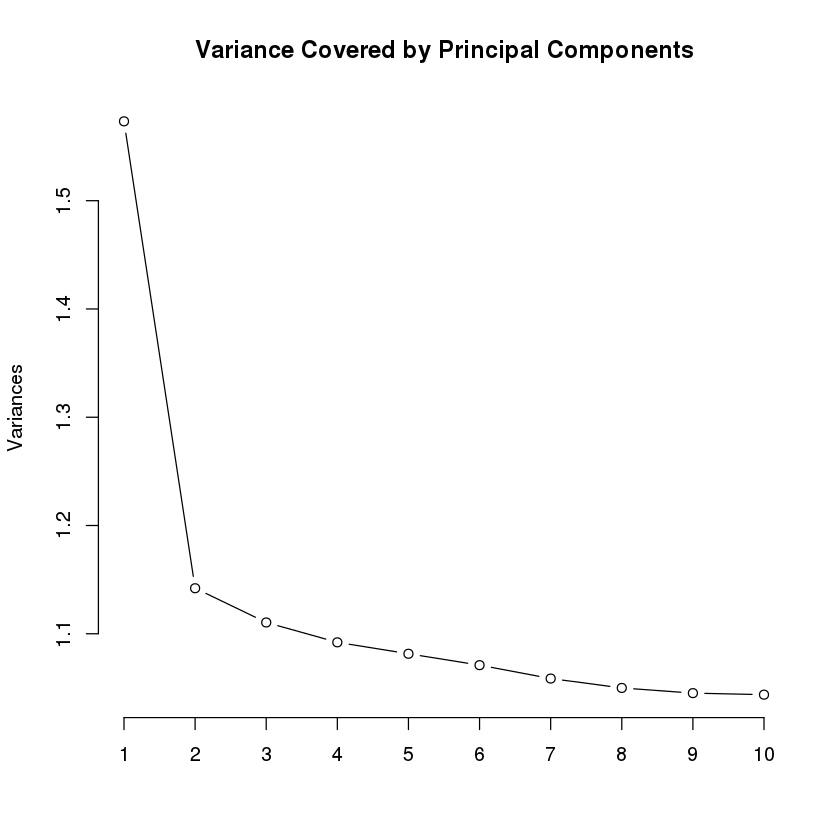

In [92]:
#convert columns to numeric
for(name in names(train)[which(sapply(train, class) =='factor')]){
    for(level in unique(train$name)){
      train[paste("dummy", level, sep = "_")] <- ifelse(train$name == level, 1, 0)
    }   
}
train_numeric <- train
train_numeric <- train_numeric[ , -which(names(train_numeric) %in% names(train)[which(sapply(train, class) =='factor')])]
transaction.pca <- prcomp(train_numeric,
                 center = TRUE,
                 scale. = TRUE)
plot(transaction.pca, type = "l", main = "Variance Covered by Principal Components")

### Visualizing the model

Transforming the model for visualization:

In [93]:
library(sigmoml)
library(partykit)
library(plyr)

rulesDataFrame <- sigmoml::getRules(classifierModel)
# replacing NA with an empty string for formatting
# rulesDataFrame[is.na(rulesDataFrame)] <- ""

Loading required package: grid

Attaching package: 'grid'

The following object is masked from 'package:SparkR':

    explode


Attaching package: 'plyr'

The following objects are masked from 'package:SparkR':

    arrange, count, desc, join, mutate, rename, summarize, take



Graph representation

In [94]:
library(brunel)

brunel (" data('rulesDataFrame') treemap x(Level1, Level2, Level3, Level4, Level5, Level6, Level7, Level8, Level9) color(Prediction) size(Samples) label(Name) filter(Prediction) tooltip(#all)",
        width=1000, height=500, online_js=TRUE)

<!-- ~ Copyright (c) 2015 IBM Corporation and others. ~ ~ Licensed under the Apache License, Version 2.0 (the "License"); ~ You may not use this file except in compliance with the License. ~ You may obtain a copy of the License at ~ ~ http://www.apache.org/licenses/LICENSE-2.0 ~ ~ Unless required by applicable law or agreed to in writing, software ~ distributed under the License is distributed on an "AS IS" BASIS, ~ WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. ~ See the License for the specific language governing permissions and ~ limitations under the License. -->

In [95]:
library(brunel)
brunel (" data('rulesDataFrame') tree(prune:20) y(Level1, Level2, Level3, Level4, Level5, Level6, Level7, Level8, Level9) color(Prediction) label(Prediction) size(samples) tooltip(#all) legends(none)",
        width=1000, height=800, online_js=TRUE)

<!-- ~ Copyright (c) 2015 IBM Corporation and others. ~ ~ Licensed under the Apache License, Version 2.0 (the "License"); ~ You may not use this file except in compliance with the License. ~ You may obtain a copy of the License at ~ ~ http://www.apache.org/licenses/LICENSE-2.0 ~ ~ Unless required by applicable law or agreed to in writing, software ~ distributed under the License is distributed on an "AS IS" BASIS, ~ WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. ~ See the License for the specific language governing permissions and ~ limitations under the License. -->

Native R visualization

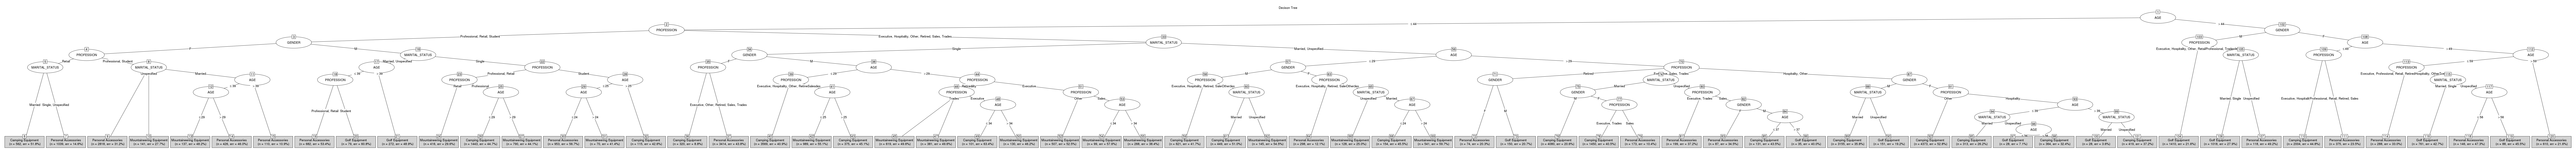

In [96]:
library(repr)

# Change plot size to 136 x 8
options(repr.plot.width=136, repr.plot.height=8)

plot(classifierModel, type="simple",main="Decison Tree", drop_terminal = TRUE)